In [1]:
import sys
import math

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
import lightning as L

from dal_toolbox.models.utils.random_features import RandomFeatureGaussianProcess
from dal_toolbox.models.utils.spectral_normalization import spectral_norm_linear
from dal_toolbox.models.sngp import SNGPTrainer

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


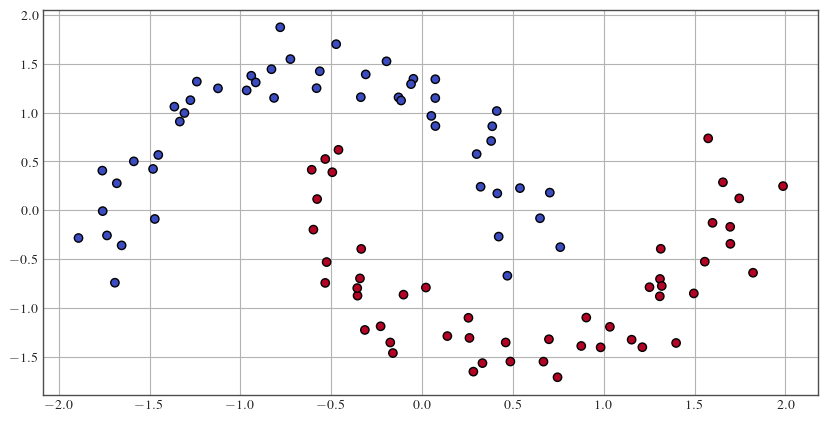

In [2]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(
            in_features=feature_dim,
            out_features=num_classes,
            **gp_params,
        )
        self.act = nn.ReLU()
    

    def forward(self, x, mean_field=False, return_cov=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        else:
            out = self.last(x, return_cov=return_cov)

        return out

In [4]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz, mean_field=True)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [1] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.6870 (0.6870) acc1: 59.0000 (59.0000) time: 0.1664 data: 0.0011 max mem: 24
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.2868 (0.2868) acc1: 94.0000 (94.0000) time: 0.0050 data: 0.0006 max mem: 31
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.1864 (0.1864) acc1: 97.0000 (97.0000) time: 0.0047 data: 0.0007 max mem: 31
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.1441 (0.1441) acc1: 98.0000 (98.0000) time: 0.0061 data: 0.0008 max mem: 31
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.1002 (0.1002) acc1: 100.0000 (100.0000) time: 0.0058 data: 0.0008 max mem: 31
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.0639 (0.0639) acc1: 100.0000 (100.0000) time: 0.0053 data: 0.0006 max mem: 31
Epoch [6] Total time: 0:00:00
Epoch [7] [0/1] eta: 0:00:00 lr: 0.0100 loss: 0.0417 (0.0417) acc1: 100.

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


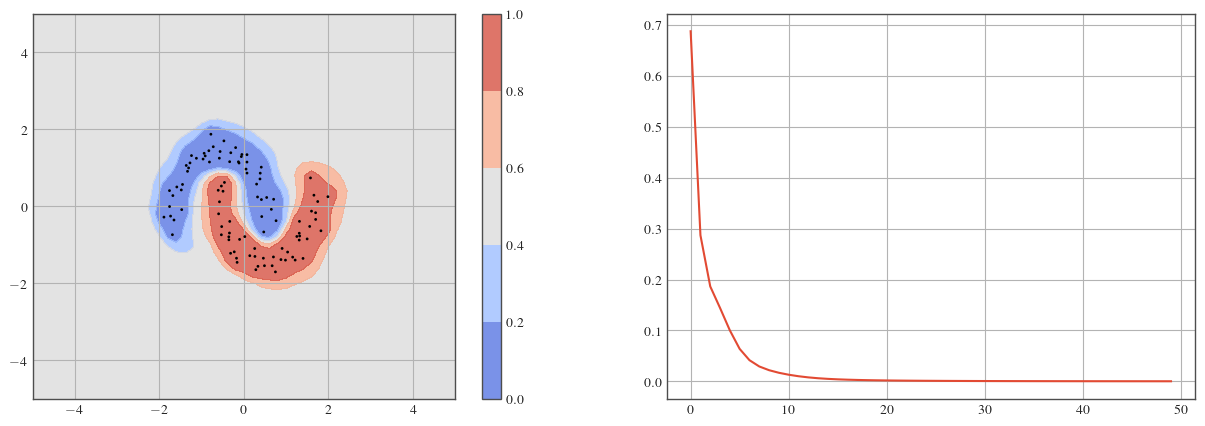

In [5]:
spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=0.05,
    random_feature_type='orf',
    scale_random_features=False,
    # normalize_input=False,
    # mean_field_factor=1,
    # cov_momentum=-1,
    # ridge_penalty=1
)
epochs = 50

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = Model(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)
# history = MetricHistory()
# trainer = L.Trainer(max_epochs=epochs, callbacks=[history])
# trainer.fit(model, train_loader)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2, momentum=.9)
trainer = SNGPTrainer(
    model,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    num_epochs=50,
)
history = trainer.fit(train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(model, X, y)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history['train_history']])
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/denis/Documents/projects/uncertainty_evaluation/dal_toolbox/models/sngp/base.py:61: UserWarning: Using default optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.01
).
  warnings.warn(f'Using default optimizer: {optimizer}.')

  | Name    | Type             | Params
---------------------------------------------
0 | model   | Model            | 101 K 
1 | metrics | ModuleDict       | 0     
2 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.406     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/s

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s, v_num=92, train_loss=0.000371] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s, v_num=92, train_loss=0.000371]


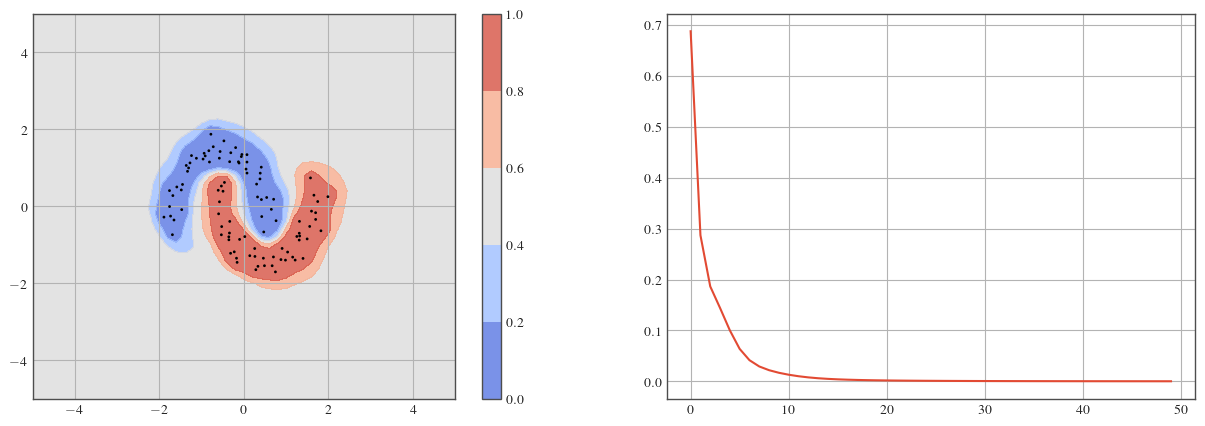

In [6]:
from dal_toolbox.models.sngp import SNGPModel
from dal_toolbox.models.utils.callbacks import MetricHistory

spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=0.05,
    random_feature_type='orf',
    scale_random_features=False,
    # normalize_input=False,
    # mean_field_factor=1,
    # cov_momentum=-1,
    # ridge_penalty=1
)
epochs = 50

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = SNGPModel(
    Model(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)
)
history = MetricHistory()
trainer = L.Trainer(max_epochs=epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(model, X, y)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()